In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

# KMeans

In [2]:
class KMeans:
    def __init__(self, k=2, eps=0.00001, max_iter=1000):
        self.k = k
        self.eps = eps
        self.max_iter = max_iter
        self.centroids = []

    def fit(self, data):
        for i in range(self.k):
            self.centroids.append(data[np.random.randint(0, data.shape[0])])

        for _ in range(self.max_iter):
            classifications = [[] for i in range(self.k)]

            for feature_set in data:
                distances = [np.linalg.norm(feature_set - self.centroids[k]) for k in range(self.k)]
                classification = np.argmin(distances)
                classifications[classification].append(feature_set)

            prev_centroids = deepcopy(self.centroids)

            for k in range(self.k):
                self.centroids[k] = np.average(classifications[k], axis=0)

            optimized = True

            for k in range(self.k):
                original_centroid = prev_centroids[k]
                current_centroid = self.centroids[k]
                if np.linalg.norm(current_centroid - original_centroid) > self.eps:
                    optimized = False

            if optimized:
                break

        return self.centroids

    def predict(self, data):
        predictions = []
        for feature_set in data:
            distances = [np.linalg.norm(feature_set - self.centroids[i]) for i in range(self.k)]
            predictions.append(np.argmin(distances))
        return np.array(predictions)

# Data

In [3]:
penguins = pd.read_csv('../data/penguins.csv')

In [4]:
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [5]:
penguins = penguins.dropna()
penguins = penguins.reset_index().drop(columns=['index'])
penguins

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
328,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
329,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
330,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
331,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [6]:
y = penguins.species
y = y.replace(to_replace=['Adelie', 'Chinstrap', 'Gentoo'], value=[0, 1, 2])
y

0      0
1      0
2      0
3      0
4      0
      ..
328    2
329    2
330    2
331    2
332    2
Name: species, Length: 333, dtype: int64

In [7]:
penguins['fromTorgersen'] = pd.Series(penguins.island == 'Torgersen')
penguins['fromBiscoe'] = pd.Series(penguins.island == 'Biscoe')
penguins['fromDream'] = pd.Series(penguins.island == 'Dream')
penguins['sex'] = pd.Series(penguins.sex == 'FEMALE')
X = penguins.drop(columns=['species', 'island'])

In [8]:
X = X.astype({'sex': 'int32', 'fromTorgersen': 'int32', 'fromBiscoe': 'int32','fromDream': 'int32'})

In [9]:
def minmax(data):
    value_min = min(data)
    value_max = max(data)
    return value_min, value_max


def normalize(series):
    data = list(series)
    v_min, v_max = minmax(data)
    delta = v_max - v_min
    for i in range(len(data)):
        data[i] = (data[i] - v_min) / delta
    return pd.Series(data)

In [10]:
X.culmen_length_mm = normalize(penguins.culmen_length_mm)
X.culmen_depth_mm = normalize(penguins.culmen_depth_mm)
X.flipper_length_mm = normalize(penguins.flipper_length_mm)
X.body_mass_g = normalize(penguins.body_mass_g)

In [11]:
X.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,fromTorgersen,fromBiscoe,fromDream
0,0.254545,0.666667,0.152542,0.291667,0,1,0,0
1,0.269091,0.511905,0.237288,0.305556,1,1,0,0
2,0.298182,0.583333,0.389831,0.152778,1,1,0,0
3,0.167273,0.738095,0.355932,0.208333,1,1,0,0
4,0.261818,0.892857,0.305085,0.263889,0,1,0,0


# Real clusters

In [12]:
X_pca = PCA(n_components=2).fit_transform(X)

def display_clusters(labels, title):
    plt.figure(figsize=(6, 6))
    unique_labels = np.unique(labels)
    for i in range(len(unique_labels)):
        label = unique_labels[i]
        cur_xs = X_pca[labels == label, 0]
        cur_ys = X_pca[labels == label, 1]
        plt.scatter(cur_xs, cur_ys, alpha=0.5, label=label)
    plt.title(title)
    plt.legend()
    plt.show()

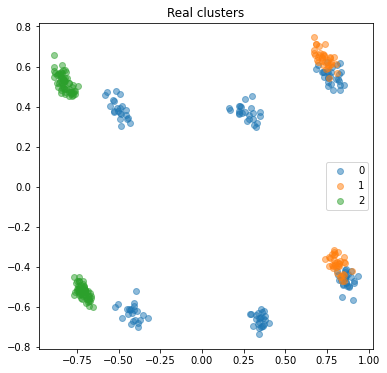

In [13]:
display_clusters(y, "Real clusters")

In [14]:
import numpy as np

from sklearn.metrics import confusion_matrix

def rand_index(true_labels, pred_labels):
    tp_fn = 0
    for fisrt_el_idx in range(true_labels.shape[0]):
        for second_el_idx in range(fisrt_el_idx + 1, true_labels.shape[0]):
            if true_labels[fisrt_el_idx] == true_labels[second_el_idx] and pred_labels[fisrt_el_idx] == pred_labels[second_el_idx]:
                tp_fn += 1
            elif true_labels[fisrt_el_idx] != true_labels[second_el_idx] and pred_labels[fisrt_el_idx] != pred_labels[second_el_idx]:
                tp_fn += 1
    return 2 * tp_fn / true_labels.shape[0] / true_labels.shape[0]

def silhouette(X, pred_labels, centroids):
    clusters, counts = np.unique(pred_labels, return_counts=True)
    n_clusters = len(clusters)

    clusters_X = [np.array([]) for i in range(n_clusters)]
    for cluster in clusters:
        clusters_X[cluster] = X[pred_labels == cluster, :]

    silhouettes = []
    for cluster in clusters:
        internal_distance = np.mean([np.linalg.norm(x - centroids[cluster]) for x in clusters_X[cluster]])

        external_distances = []
        for other_cluster in clusters:
            if other_cluster != cluster:
                distances = [np.linalg.norm(x - centroids[other_cluster]) for x in clusters_X[cluster]]
                external_distances.append(np.mean(distances) if len(distances) else 0.0)

        external_distance = min(external_distances) if len(external_distances) else 0.0
        silhouettes.append((external_distance - internal_distance) / max([internal_distance, external_distance]))

    return sum(silhouettes) / n_clusters

In [15]:
X = X.to_numpy()

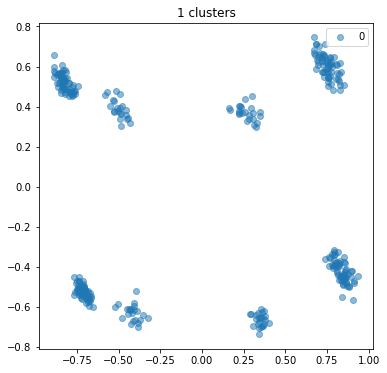

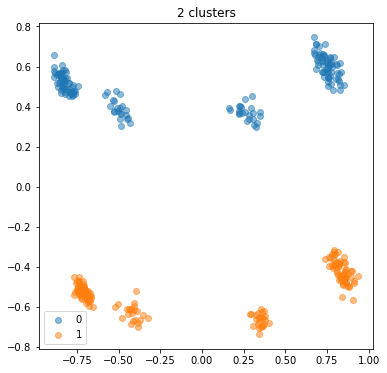

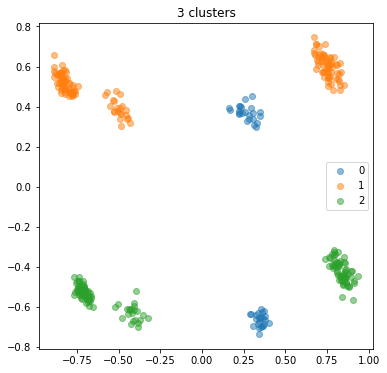

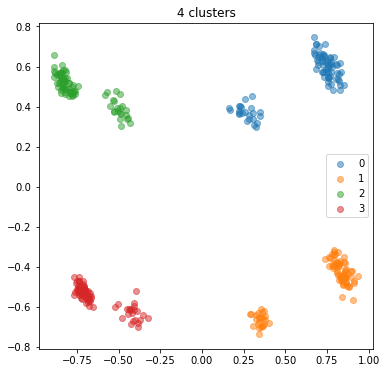

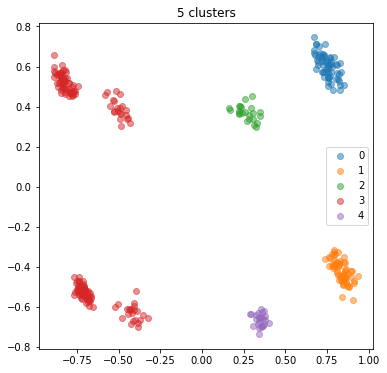

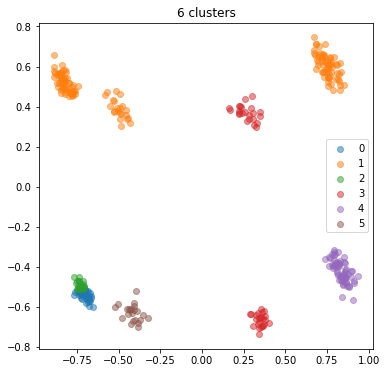

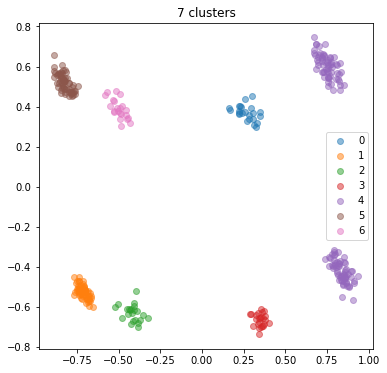

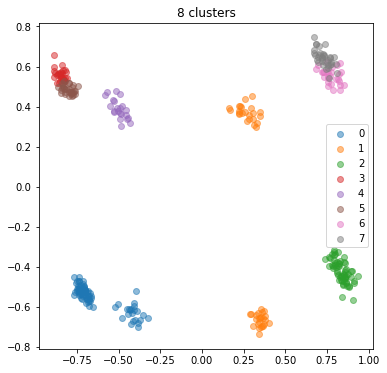

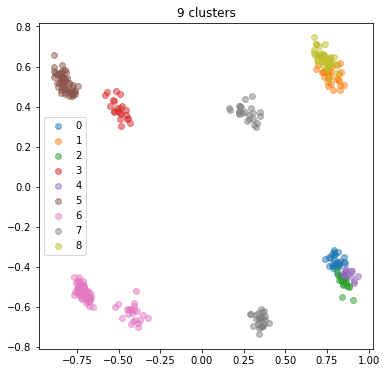

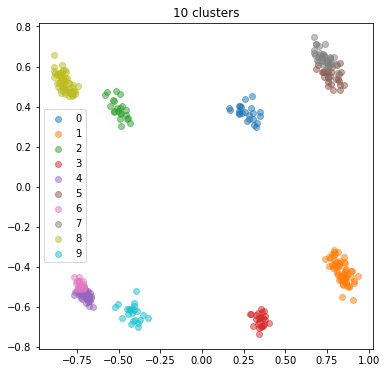

In [16]:
external_metrics = []
internal_metrics = []

for i in range(1, 11):
    kMean = KMeans(k=i)
    centroids = kMean.fit(X)
    y_pred = kMean.predict(X)
    if i == 1:
        internal_metrics.append(0.0)
    else:
        internal_metrics.append(silhouette(X, y_pred, centroids))

    external_metrics.append(rand_index(y, y_pred))
    display_clusters(y_pred, str(i) + ' clusters')

In [17]:
def display_metrics(n_clusters, metrics, title):
    plt.figure(figsize=(8, 6))
    plt.grid(linestyle='--')
    plt.plot(n_clusters, metrics, linestyle='-', marker='.', color='r')
    plt.title(title)
    plt.xlabel("Clusters count")
    plt.ylabel("Metrics value")
    plt.show()

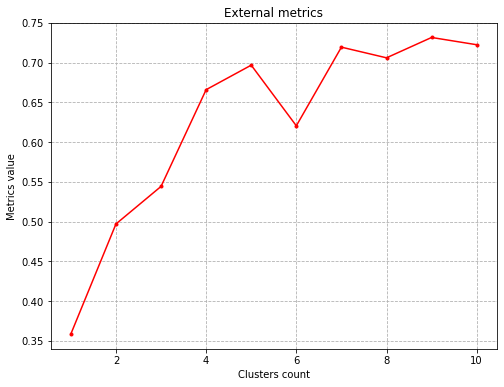

In [18]:
display_metrics(range(1, 11), external_metrics, 'External metrics')

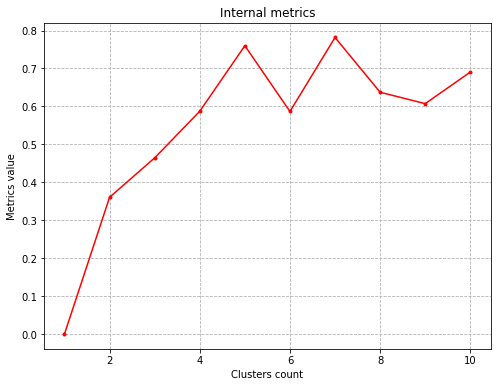

In [19]:
display_metrics(range(1, 11), internal_metrics, 'Internal metrics')